# Time Series Analysis

**Introduction**

In this notebook, we will:
1. Narrow down our analysis to focus on one stock, Facebook.
2. Understand the changes of FB stock prices on each day.
3. Predict future stock prices

Data source: Yahoo
Using pandas datareader, I will get stock information for the FAANG tech companies:
* Facebook (FB)
* Apple (AAPL)
* Amazon (AMZN)
* Netflix (NFLX)
* Google (GOOGL)

In [1]:
import pandas_datareader
from pandas_datareader import data, wb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


### Part 1: Load data

In [2]:
start = datetime.datetime(2012, 5, 18) #when FB IPO
end = datetime.datetime(2020, 1, 1)

#Facebook
FB = data.DataReader("FB","yahoo",start,end)

# #Apple
# AAPL = data.DataReader("AAPL","yahoo",start,end)

# #Amazon 
# AMZN = data.DataReader("AMZN","yahoo",start,end)

# #Netflix
# NFLX = data.DataReader("NFLX","yahoo",start,end)

# #Google
# GOOGL = data.DataReader("GOOGL", "yahoo",start,end)

# #Create a sorted list of tickers
# tickers = ['FB','AAPL','AMZN','NFLX','GOOGL']
# tickers = sorted(tickers)

# #Concat data into one dataframe
# stocks = pd.concat([FB,AAPL,AMZN,NFLX,GOOGL],axis=1, keys= tickers)
# stocks.columns.names=['Company Tickers','Stock Info']

### Part 2: Perform Dickey-Fuller test

In [3]:
#Define a function that performs Dickey-Fuller test and plot the moving average/moving std:

def DF_test(data, winnum):
    dftest = adfuller(data, autolag = 'AIC')

    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used', 'Num of obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print('Results of Dickey-Fuller test:')    
    print(dfoutput)
    
    rolmean = data.rolling(window=winnum).mean()
    rolstd = data.rolling(window=winnum).std()

    plt.figure(figsize=(20,10))

    ig, ax = plt.subplots(figsize=(20, 5))
    mean = ax.plot(rolmean, color='red',label='Rolling mean')
    std = ax.plot(rolstd, color = 'black',label ='Rolling std')
    org = ax.plot(data, color='blue', label ='Original')

    plt.title('Rolling mean and standard deviation')
    plt.legend(loc= 'best')
    plt.show(block=False)

Results of Dickey-Fuller test:
Test Statistic            -0.451877
p-value                    0.901070
#Lags Used                 0.000000
Num of obs              1917.000000
Critical Value (1%)       -3.433766
Critical Value (5%)       -2.863049
Critical Value (10%)      -2.567573
dtype: float64


<Figure size 1440x720 with 0 Axes>

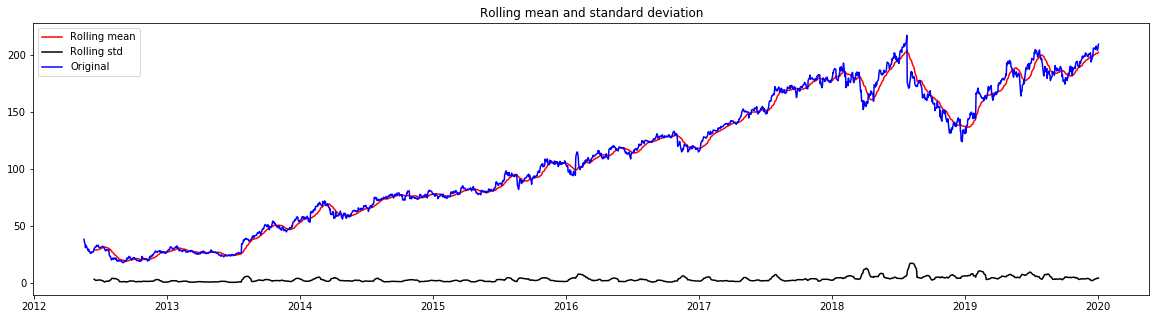

In [4]:
DF_test(FB['Close'], 20)

High p-value indicates that the data is not stationary.

### Trend decomposition

Results of Dickey-Fuller test:
Test Statistic            -0.761126
p-value                    0.830275
#Lags Used                 0.000000
Num of obs              1917.000000
Critical Value (1%)       -3.433766
Critical Value (5%)       -2.863049
Critical Value (10%)      -2.567573
dtype: float64


<Figure size 1440x720 with 0 Axes>

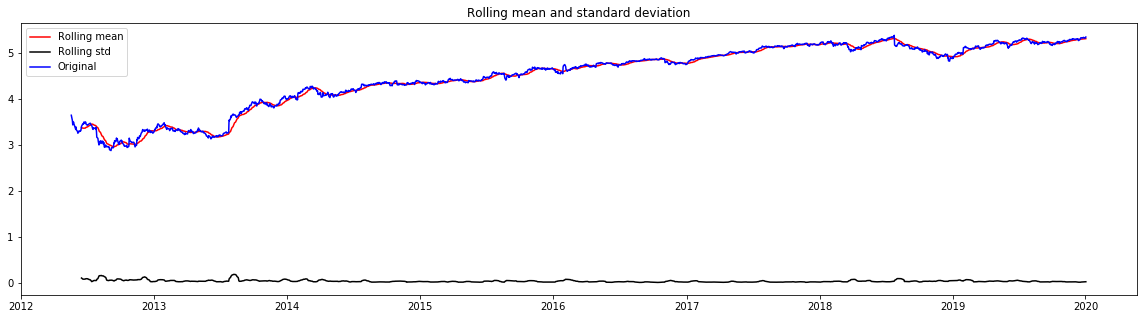

In [5]:
FB_log = np.log(FB['Close'])
#Check DF test with this new variable

DF_test(FB_log,20)

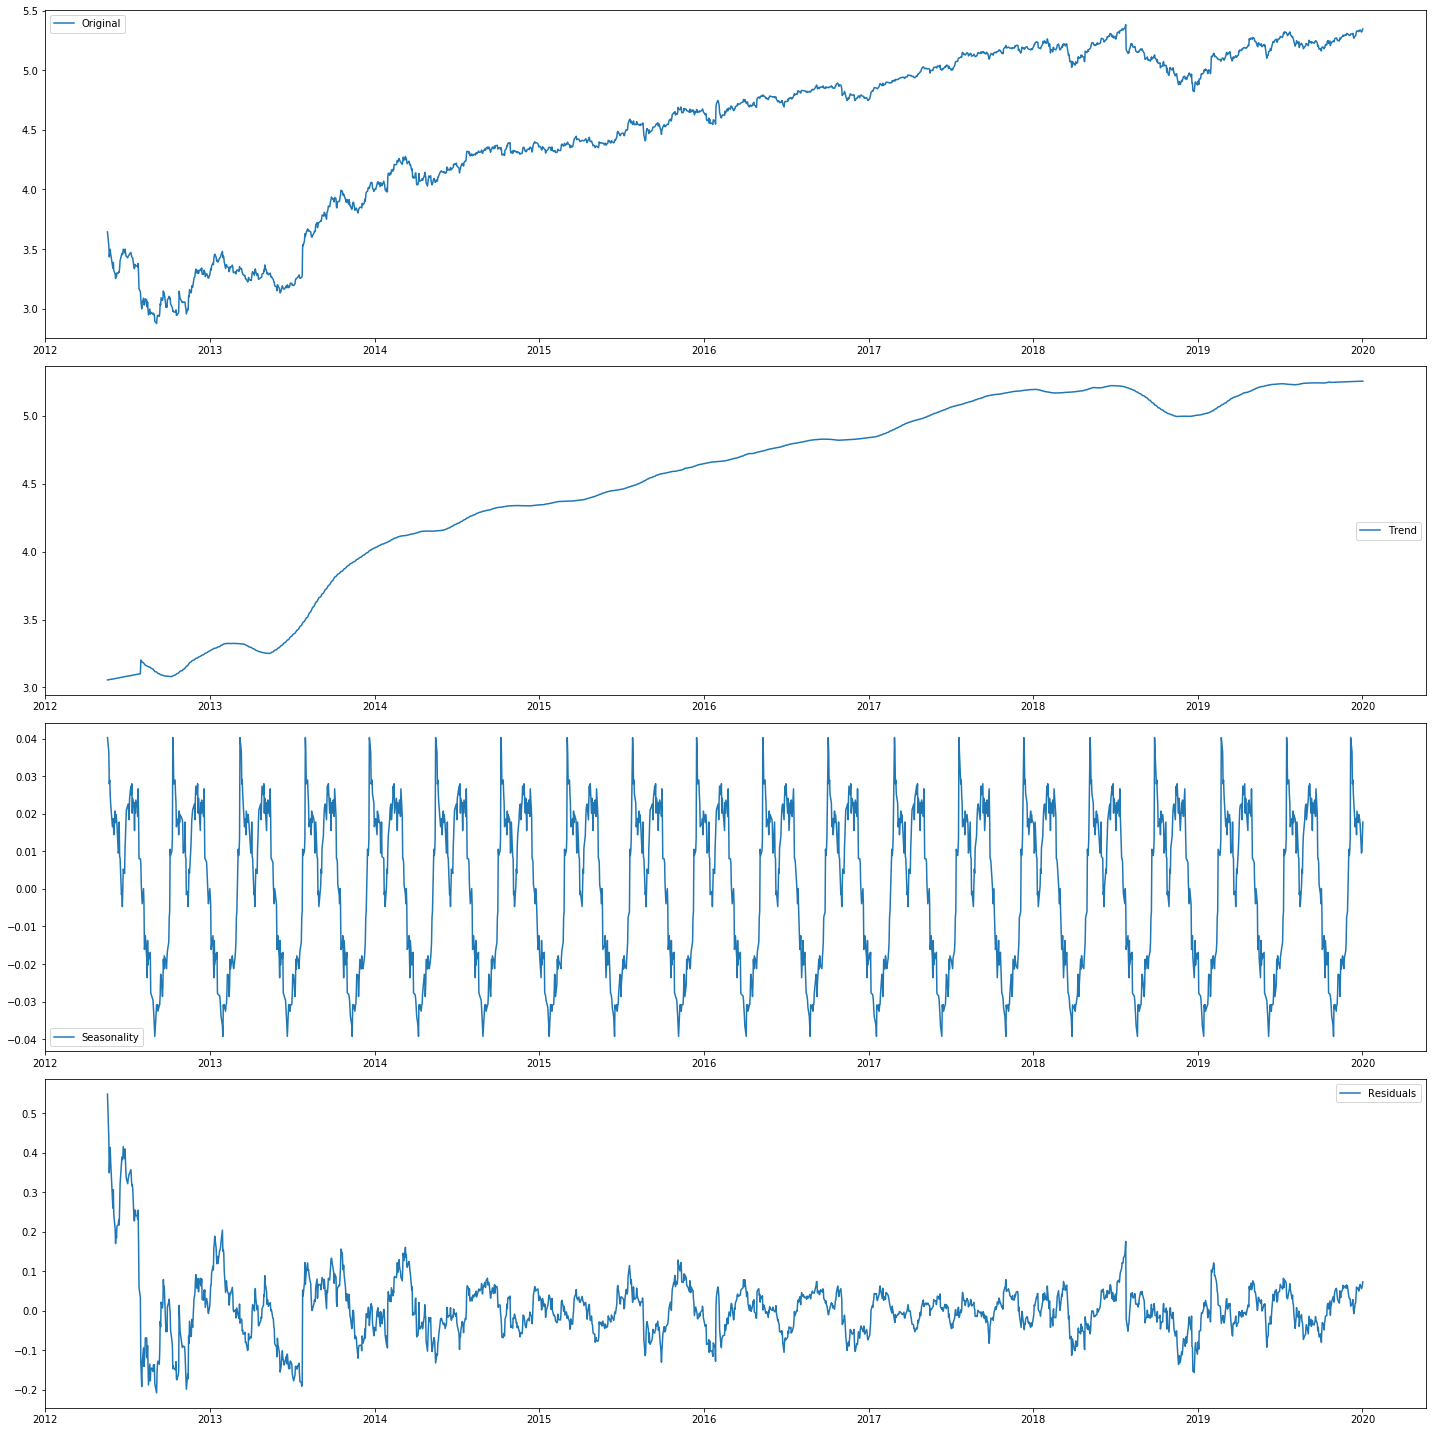

In [6]:
decomposition = seasonal_decompose(FB_log,model='additive',freq=100, extrapolate_trend = 100)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20, 20))

plt.subplot(411)
plt.plot(FB_log,label='Original')
plt.legend(loc= 'best')

plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='center right')

plt.subplot(413)
plt.plot(seasonal, label ='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

It is clear that the trend of FB stocks is increasing. It seems to be seasonal (a season seems to be half a year).

Results of Dickey-Fuller test:
Test Statistic         -8.453477e+00
p-value                 1.638452e-13
#Lags Used              0.000000e+00
Num of obs              1.917000e+03
Critical Value (1%)    -3.433766e+00
Critical Value (5%)    -2.863049e+00
Critical Value (10%)   -2.567573e+00
dtype: float64


<Figure size 1440x720 with 0 Axes>

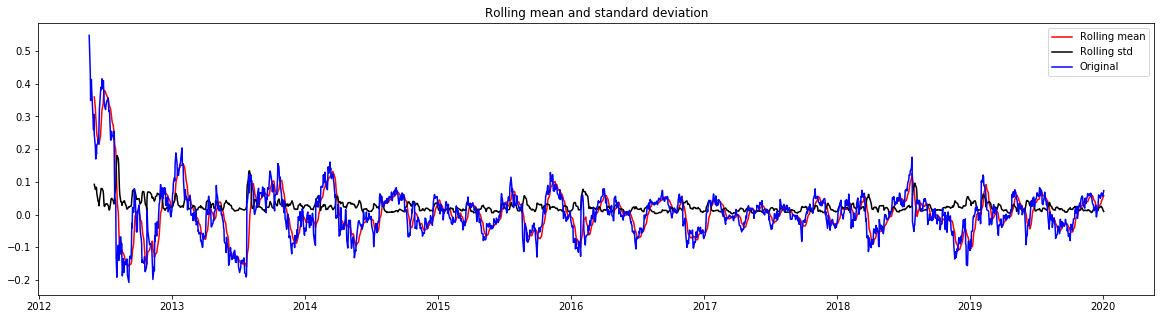

In [7]:
decomposedLogData = residual
DF_test(decomposedLogData,10)

The decomposed data is stationary. The rolling std is almost flat though the moving average is not quite.

### Part 3: ARIMA Model and predictions

**Autocorrelation function**

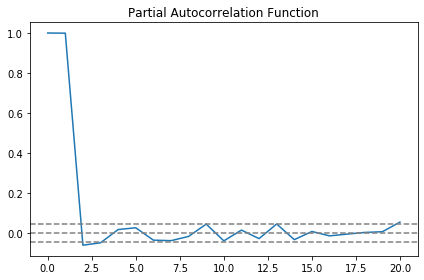

In [8]:
from statsmodels.tsa.stattools import pacf

lag_pacf = pacf(FB_log, nlags = 20)

#Plot pacf - partial autocorrelation function

plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(FB_log)), linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(FB_log)), linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

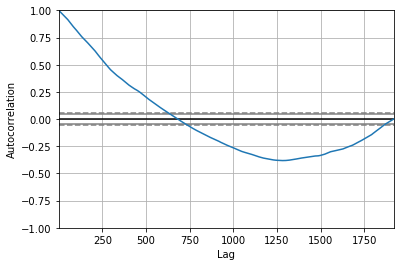

In [9]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(FB_log)
#plt.xlabel('Lag')

The number of lags are very huge if we analyze time series data by days. But we will continue and later on compare the two methods.

**ARIMA (Auto-regressive + Moving-average)**

A nonseasonal ARIMA model is classified as an "ARIMA(p,d,q)" model, where: p is the number of autoregressive terms, d is the number of nonseasonal differences needed for stationarity, and. q is the number of lagged forecast errors in the prediction equation. ACF can be used to figure out the best order of the MA model and PACF can be used to find the best order of AR model.
Check out for more details of choosing the orders: https://people.duke.edu/~rnau/411arim2.htm

Results of Dickey-Fuller test:
Test Statistic           -43.708155
p-value                    0.000000
#Lags Used                 0.000000
Num of obs              1916.000000
Critical Value (1%)       -3.433768
Critical Value (5%)       -2.863050
Critical Value (10%)      -2.567574
dtype: float64


<Figure size 1440x720 with 0 Axes>

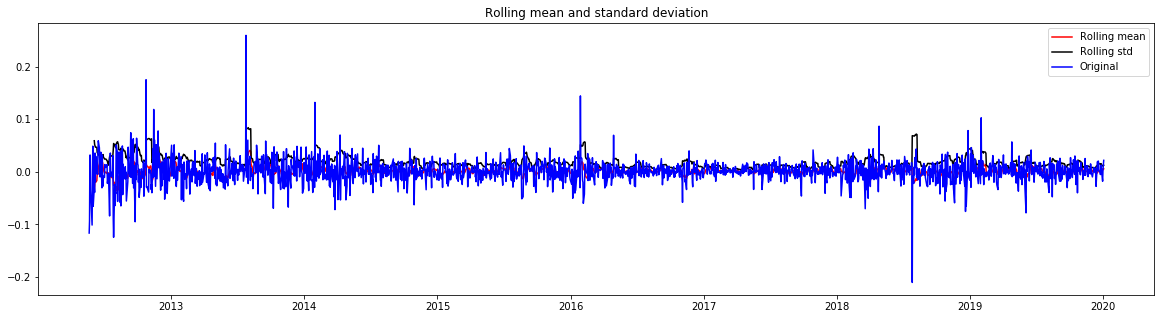

In [10]:
#Select data difference
FB_diffshift = FB_log - FB_log.shift().fillna(0)

FB_diffshift = FB_diffshift[1:]
#Check DF test
DF_test(FB_diffshift,10)


This new variable is stationary.

In [11]:
#Split data into train and test sets

FB_train = FB_log.ix[start: '2017-12-31']
FB_test =FB_log.ix['2018-01-01': end]

FB_diffshift_train = FB_diffshift.ix[start: '2017-12-31']
FB_diffshift_test = FB_diffshift.ix['2018-01-01': end]

In [12]:
def plot_RSS(model_name, results_data):
    plt.figure(figsize=(20,7))
    fitted_values = results_data.fittedvalues
    plt.plot(FB_diffshift_train)
    plt.plot(fitted_values, color='red')
    plt.title(model_name+' Model'+' | RSS: %.4f'% sum((fitted_values - FB_diffshift_train).dropna()**2),fontsize =20)
    plt.tight_layout()

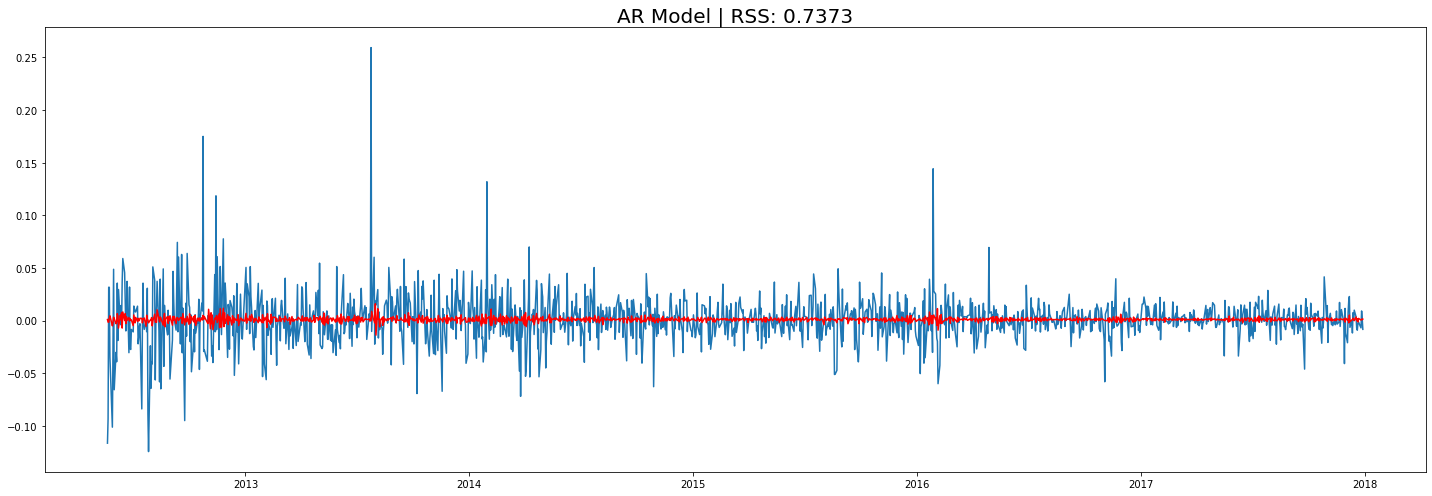

In [13]:
#AR model (q = 0)

model = ARIMA(FB_train, order= [10,1,0])
results_AR = model.fit()

plot_RSS('AR', results_AR)

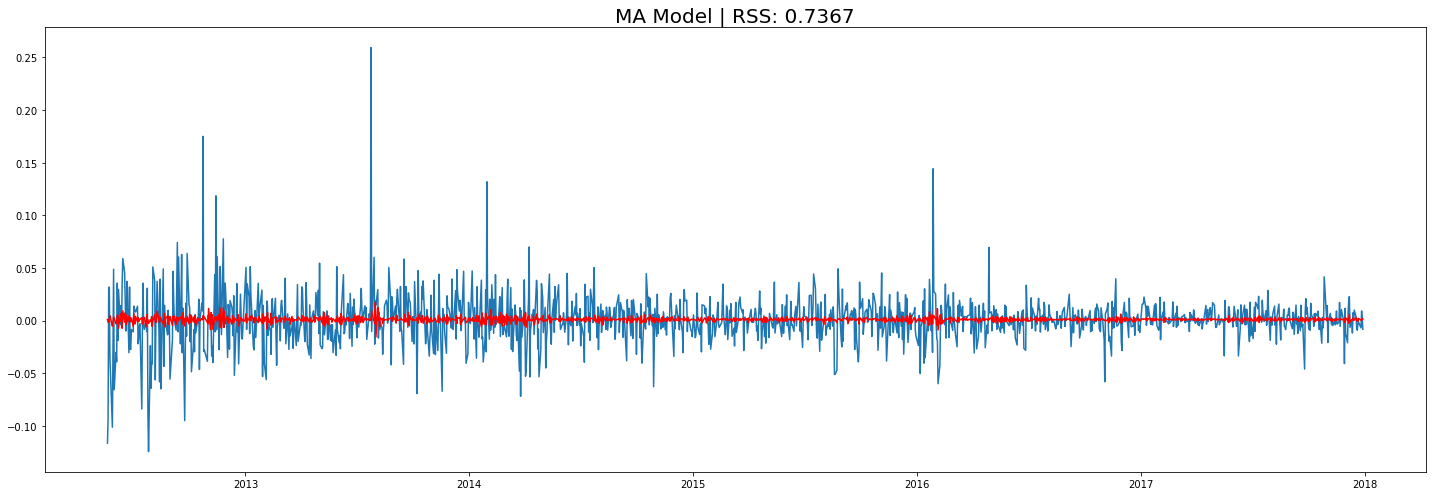

In [14]:
#MA model (p =0)

model = ARIMA(FB_train, order= [0,1,10])
results_MA = model.fit()

plot_RSS('MA', results_MA)

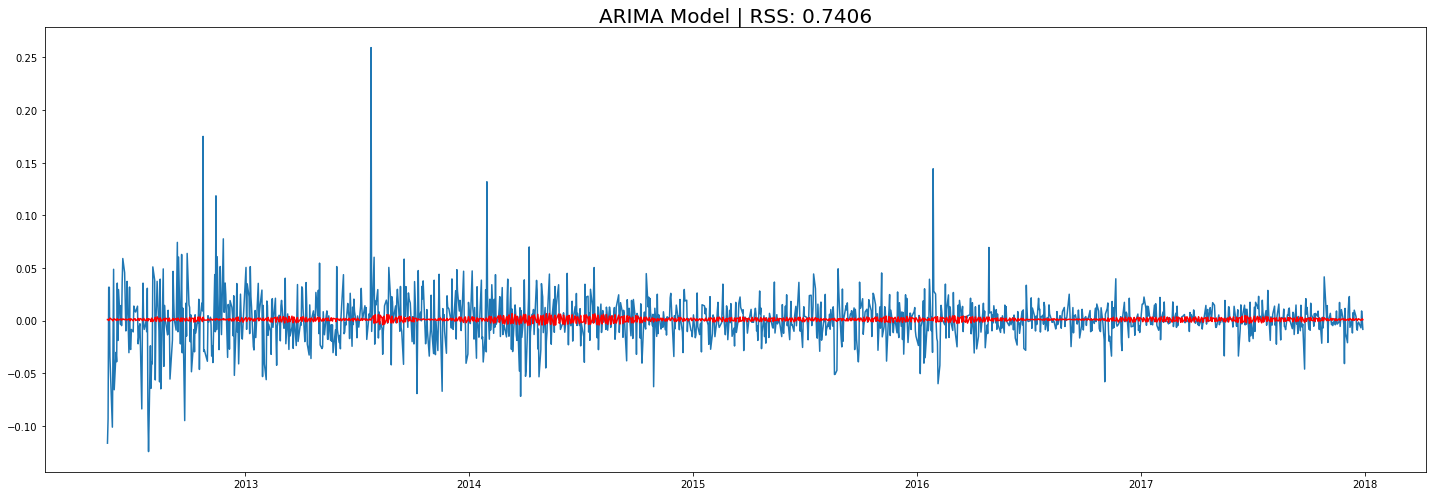

In [15]:
# ARIMA Model
model = ARIMA(FB_train, order= (2,1,2))
results_ARIMA = model.fit(disp = False)

plot_RSS('ARIMA', results_ARIMA)

### Give predictions

Compare ARIMA and AR models

1. ARIMA

In [16]:
def plot_predictions_of_diff(model_name, results_data):
    fitted_values = results_data.fittedvalues
    predictions_diff = pd.Series(fitted_values,copy=True)
    plt.figure(figsize=(20,5))
    plt.plot(predictions_diff)
    plt.title('Predicted value changes for '+ model_name)

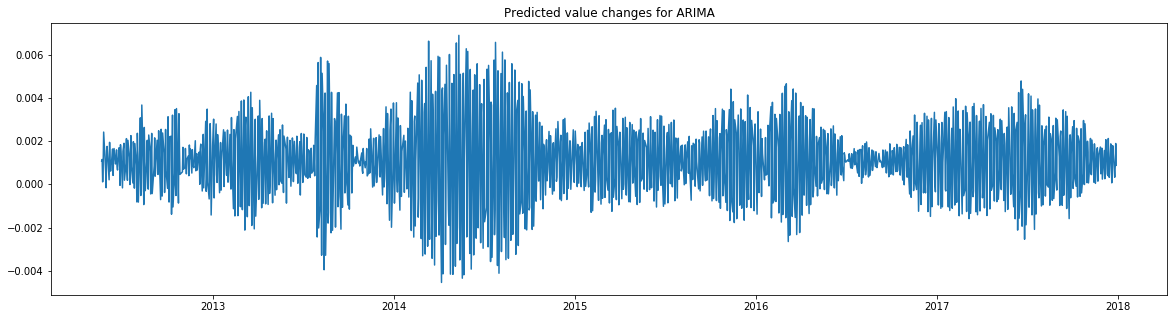

In [17]:
plot_predictions_of_diff('ARIMA', results_ARIMA)

In [18]:
#Convert it to actual terms

def convert_and_plot_actual_pred(model_name, results_data, forecast_range_inmonths):
    #Plot original and predicted values
    fitted_values = results_data.fittedvalues
    predictions_diff = pd.Series(fitted_values,copy=True)
    predictions_diff_cumsum = predictions_diff.cumsum()

    predictions_log= FB_train.add(predictions_diff_cumsum,fill_value=0)
    #predictions_log= FB_train.add(predictions_diff,fill_value=0)
    predictions = np.exp(predictions_log)
    
    plt.figure(figsize = (20,7))
    plt.plot(FB['Close'].ix[start:'2017-12-31'], label='Original')
    plt.plot(predictions, label='Predicted by '+model_name)
    plt.legend(loc='best')
    
    #Plot future predictions
    number_days_ahead = 67*30 +  forecast_range_inmonths*30 #67 is total of months in our training set
    fig, ax = plt.subplots(figsize=(20,10))
    results_data.plot_predict(1,number_days_ahead, ax=ax,alpha=0.05)

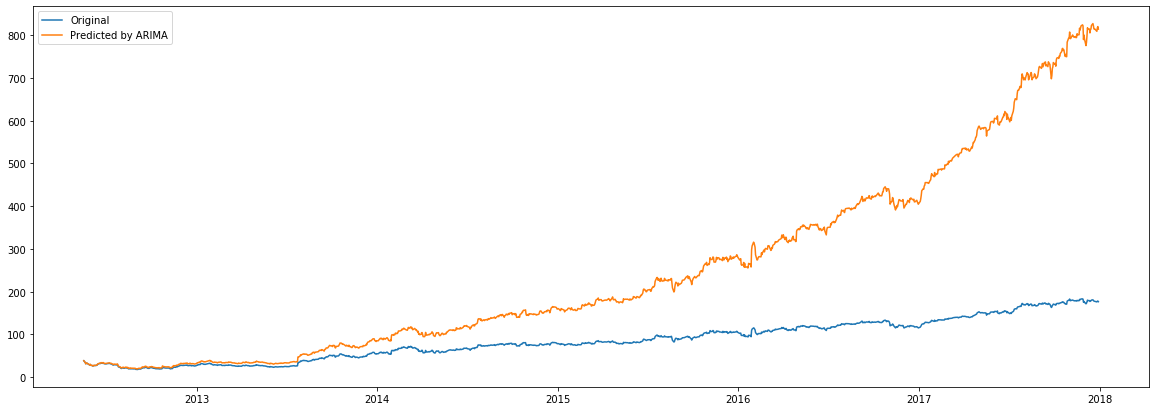

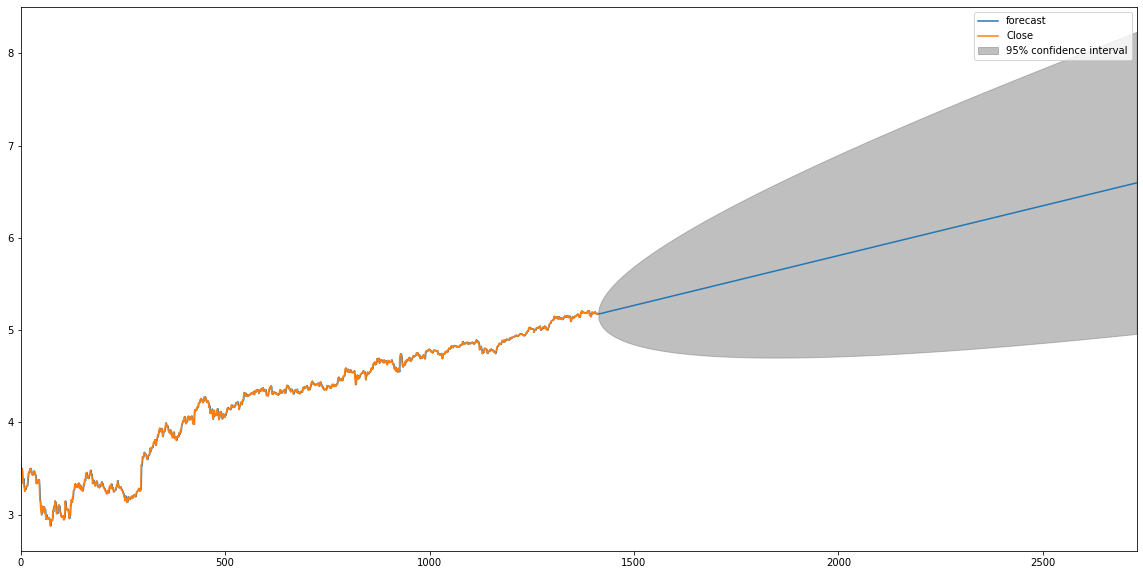

In [19]:
convert_and_plot_actual_pred('ARIMA', results_ARIMA, 24)

2. AR

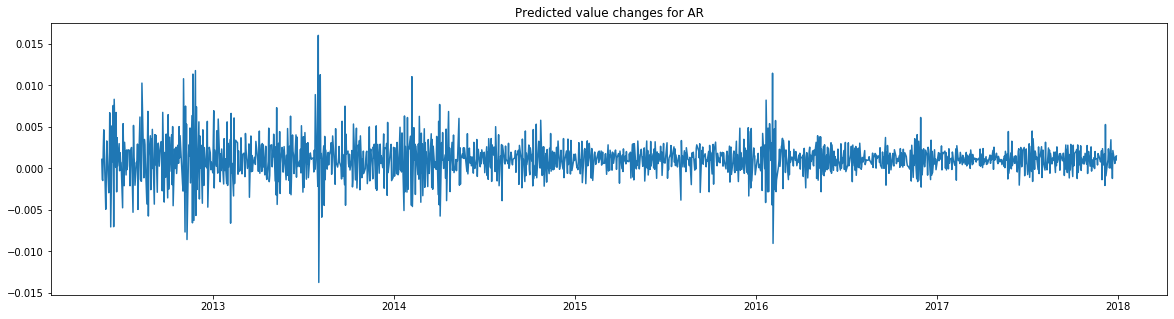

In [20]:
plot_predictions_of_diff('AR', results_AR)

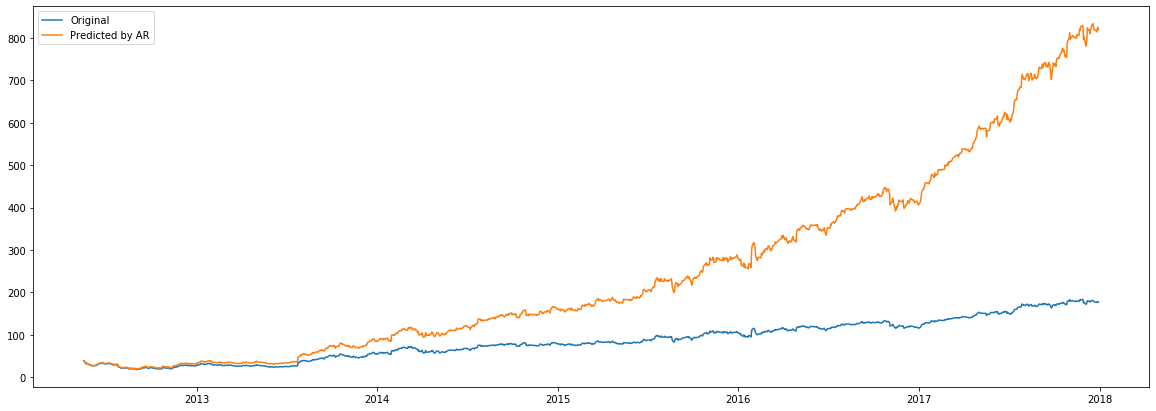

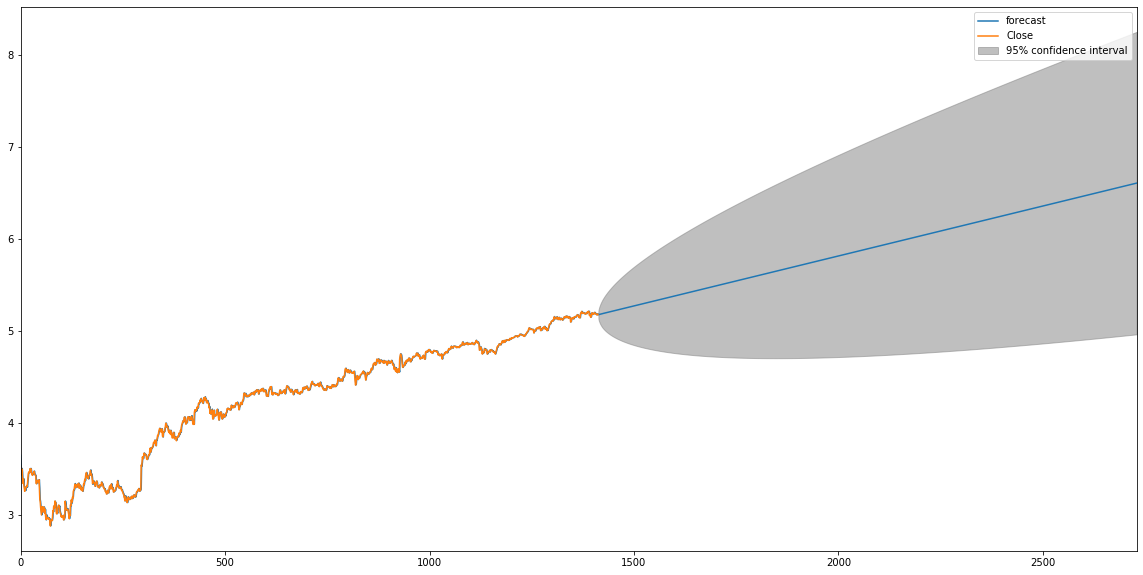

In [21]:
convert_and_plot_actual_pred('AR', results_AR, 24)

As shown, we see that analyzing time series day by days gives too much noise and not a robust result. We would check an analysis on monthly data instead.
See part 2: Times series analysis_bymonths.